In [1]:
# Transfer learning usingn SCANVI (scArches) - Python

## Install scArches following the instructions detailed here: https://scarches.readthedocs.io/en/latest/installation.html

## Load packages
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata 

# oload torch

# sca.zenodo.download_model("https://zenodo.org/records/6962901/files/scarches_SCANVI_core_GBmap.zip","./scraches_down",make_dir=True)
# exit()

# x = torch.load(
#     "/Users/carbs/Downloads/Spatial_Meta/scarchesFiles/scarches_SCANVI_core_GBmap/model_params.pt",
#     map_location=torch.device("cpu"),
# )
# # it appears its state dict directly save it as a model
# # this is full state dict directly
# # step one back and
# p = {}
# p["model_state_dict"] = x

# torch.save(
#     p,
#     "/Users/carbs/Downloads/Spatial_Meta/scarchesFiles/scarches_SCANVI_core_GBmap/model.pt",
# )


def read_and_qc(sample_name, path="./visium/"):
    r"""This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(
        path + str(sample_name) + "/outs/",
        library_id=sample_name,
        count_file="filtered_feature_bc_matrix.h5",
    )
    adata.obs["sample"] = sample_name
    adata.var["SYMBOL"] = adata.var_names
    adata.var_names_make_unique()  # CHANGE THIS PART OF THE CODE TO ALLOW GENE SYMBOL

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var["MT_gene"] = [gene.startswith("mt-") for gene in adata.var["SYMBOL"]]
    # remove MT genes for spatial mapping (keeping their counts in the object)
    adata.obsm["MT"] = adata[:, adata.var["MT_gene"].values].X.toarray()
    adata = adata[:, ~adata.var["MT_gene"].values]

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs["sample"]]
    adata.obs_names = adata.obs["sample"] + "_" + adata.obs_names
    adata.obs.index.name = "spot_id"

    return adata


# load visium data
target_adata = read_and_qc(
    "A-AK40374-AK40375_225GY5LT3", path="/Users/carbs/Downloads/Spatial_Meta/visium/"
)
print(target_adata)

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
 captum (see https://github.com/pytorch/captum).
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2565 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'MT_gene'
    uns: 'spatial'
    obsm: 'spatial', 'MT'


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/4038762396.py:60: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["sample"] = [str(i) for i in adata.obs["sample"]]


In [10]:
target_adata.X

<2565x17943 sparse matrix of type '<class 'numpy.float32'>'
	with 6001394 stored elements in Compressed Sparse Row format>

In [2]:
sca.__version__

'0.5.10'

In [2]:
## Load and prepare your data
# target_adata = sc.read('path/to/your/data.h5ad') # read your data using scanpy (load AnnData object)
ref_path_coberted = (
    "/Users/carbs/Downloads/Spatial_Meta/scraches_down_converted_fromlegacy/"
)
source_adata = sc.read(
    "/Users/carbs/Downloads/Spatial_Meta/scarchesFiles/scarches_core_GBmap.h5ad"
)



# #convert convert_legacy_save

# sca.models.SCANVI.convert_legacy_save(ref_path, ref_path_coberted)

vae = sca.models.SCANVI.load(ref_path_coberted, source_adata)  # unzip scarches-SCANVI_GBmap.zip

cell_type_key = "CellID"

surgery_epochs = 500
early_stopping_kwargs_surgery = {
    # Suggested values. For more info, please consult: https://scarches.readthedocs.io/en/latest/about.html
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}





/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


INFO     File /Users/carbs/Downloads/Spatial_Meta/scraches_down_converted_fromlegacy/model.pt already downloaded   
mappinggggg ['Bhaduri2020' 'Couturier2020' 'Darmanis2017' 'Goswami2019' 'Johnson2020'
 'Mathewson2021' 'Neftel2019_10x' 'Neftel2019_smart' 'Pombo2021'
 'Richards2021' 'Sankowski2019' 'Wang2019' 'Wang2020' 'Wu2020' 'Yu2020'
 'Yuan2018' 'Zhao2020']
mappinggggg extend_categories False


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



searching for Bhaduri2020
searching for Couturier2020
searching for Darmanis2017
searching for Goswami2019
searching for Johnson2020
searching for Mathewson2021
searching for Neftel2019_10x
searching for Neftel2019_smart
searching for Pombo2021
searching for Richards2021
searching for Sankowski2019
searching for Wang2019
searching for Wang2020
searching for Wu2020
searching for Yu2020
searching for Yuan2018
searching for Zhao2020
mappinggggg ['AC-like' 'Astrocyte' 'B cell' 'CD4/CD8' 'DC' 'Endothelial' 'MES-like'
 'Mast' 'Mono' 'Mural cell' 'NK' 'NPC-like' 'Neuron' 'OPC' 'OPC-like'
 'Oligodendrocyte' 'Plasma B' 'RG' 'TAM-BDM' 'TAM-MG']
mappinggggg extend_categories False
searching for AC-like
searching for Astrocyte
searching for B cell
searching for CD4/CD8
searching for DC
searching for Endothelial
searching for MES-like
searching for Mast
searching for Mono
searching for Mural cell
searching for NK
searching for NPC-like
searching for Neuron
searching for OPC
searching for OPC-like
s

In [3]:
vae.unlabeled_category_

'Unknown'

In [9]:
source_adata.obsm

AxisArrays with keys: 

In [13]:
target_adata.obs

in_tissue array_row array_col  \
spot_id                                                                        
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1         1         0        16   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1         1        59        19   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1         1        14        94   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1         1        43         9   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1         1        47        13   
...                                                  ...       ...       ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1         1        24        64   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1         1        21         3   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1         1        31        77   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1         1        58        42   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1         1        60        30   

                                                                     sample  \
spot_id                                                                       
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1  A-AK40374-AK40375_225GY5LT3   
...                                                                     ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1  A-AK40374-AK40375_225GY5LT3   

                                                n_genes_by_counts  \
spot_id                                                             
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1               3273   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1               3273   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1               4100   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1               1878   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1               1323   
...                                                           ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1               2453   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1               1130   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1               1222   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1                989   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1                502   

                                                log1p_n_genes_by_counts  \
spot_id                                                                   
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1                 8.093768   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1                 8.093768   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1                 8.318986   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1                 7.538495   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1                 7.188413   
...                                                                 ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1                 7.805475   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1                 7.030857   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1                 7.109062   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1                 6.897705   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1                 6.220590   

                                                total_counts  \
spot_id                                 

In [3]:
target_adata.layers[
    "counts"
] = target_adata.X.copy()  # target_adata.X must be where your raw counts are stored


target_adata.obs[cell_type_key] = vae.unlabeled_category_


In [7]:
target_adata.obs

in_tissue array_row array_col  \
spot_id                                                                        
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1         1         0        16   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1         1        59        19   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1         1        14        94   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1         1        43         9   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1         1        47        13   
...                                                  ...       ...       ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1         1        24        64   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1         1        21         3   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1         1        31        77   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1         1        58        42   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1         1        60        30   

                                                                     sample  \
spot_id                                                                       
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1  A-AK40374-AK40375_225GY5LT3   
...                                                                     ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1  A-AK40374-AK40375_225GY5LT3   

                                                n_genes_by_counts  \
spot_id                                                             
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1               3273   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1               3273   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1               4100   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1               1878   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1               1323   
...                                                           ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1               2453   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1               1130   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1               1222   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1                989   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1                502   

                                                log1p_n_genes_by_counts  \
spot_id                                                                   
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1                 8.093768   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1                 8.093768   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1                 8.318986   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1                 7.538495   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1                 7.188413   
...                                                                 ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1                 7.805475   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1                 7.030857   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1                 7.109062   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1                 6.897705   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1                 6.220590   

                                                total_counts  \
spot_id                                 

In [8]:
target_adata.var

gene_ids    feature_types  genome   SYMBOL  n_cells_by_counts  \
SAMD11   ENSG00000187634  Gene Expression  GRCh38   SAMD11                 17   
NOC2L    ENSG00000188976  Gene Expression  GRCh38    NOC2L                753   
KLHL17   ENSG00000187961  Gene Expression  GRCh38   KLHL17                 81   
PLEKHN1  ENSG00000187583  Gene Expression  GRCh38  PLEKHN1                  5   
PERM1    ENSG00000187642  Gene Expression  GRCh38    PERM1                 11   
...                  ...              ...     ...      ...                ...   
TSPY1    ENSG00000258992  Gene Expression  GRCh38    TSPY1                  0   
USP9Y    ENSG00000114374  Gene Expression  GRCh38    USP9Y                 35   
DDX3Y    ENSG00000067048  Gene Expression  GRCh38    DDX3Y                221   
TMSB4Y   ENSG00000154620  Gene Expression  GRCh38   TMSB4Y                  4   
KDM5D    ENSG00000012817  Gene Expression  GRCh38    KDM5D                220   

         mean_counts  log1p_mean_counts  pct_dropout_by_counts  total_counts  \
SAMD11      0.006628           0.006606              99.337232          17.0   
NOC2L       0.413645           0.346172              70.643275        1061.0   
KLHL17      0.031579           0.031091              96.842105          81.0   
PLEKHN1     0.001949           0.001947              99.805068           5.0   
PERM1       0.004288           0.004279              99.571150          11.0   
...              ...                ...                    ...           ...   
TSPY1       0.000000           0.000000             100.000000           0.0   
USP9Y       0.013645           0.013553              98.635478          35.0   
DDX3Y       0.093567           0.089445              91.384016         240.0   
TMSB4Y      0.001559           0.001558              99.844055           4.0   
KDM5D       0.091228           0.087304              91.423002         234.0   

         log1p_total_counts  MT_gene  
SAMD11             2.890372    False  
NOC2L              6.967909    False  
KLHL17             4.406719    False  
PLEKHN1            1.791759    False  
PERM1              2.484907    False  
...                     ...      ...  
TSPY1              0.000000    False  
USP9Y              3.583519    False  
DDX3Y              5.484797    False  
TMSB4Y             1.609438    False  
KDM5D              5.459586    False  

[17943 rows x 11 columns]

In [9]:
source_adata.var

feature_types   genome  highly_variable     means  dispersions  \
TRIM63     Gene Expression  unknown             True  0.001340     0.407240   
CCP110     Gene Expression  unknown             True  0.144074     0.720043   
CCDC186    Gene Expression  unknown             True  0.137050     0.570207   
RTN1       Gene Expression  unknown             True  0.135925     0.771399   
RHOG       Gene Expression  unknown             True  0.435874     0.769815   
...                    ...      ...              ...       ...          ...   
OBSCN-AS1  Gene Expression  unknown             True  0.002452     0.254650   
H4C4       Gene Expression  unknown             True  0.002724     0.301861   
HOATZ      Gene Expression  unknown             True  0.017586     0.628281   
LINC02694  Gene Expression  unknown             True  0.002845     0.262499   
MUCL3      Gene Expression  unknown             True  0.005176     0.384323   

           dispersions_norm  highly_variable_nbatches  \
TRIM63             0.454033                         6   
CCP110             0.438280                        10   
CCDC186            0.270854                         8   
RTN1               0.519078                        11   
RHOG              -0.000273                         6   
...                     ...                       ...   
OBSCN-AS1          0.150558                         6   
H4C4               0.195486                         6   
HOATZ              0.806285                         7   
LINC02694          0.326861                         6   
MUCL3              0.380867                         5   

           highly_variable_intersection  
TRIM63                            False  
CCP110                            False  
CCDC186                           False  
RTN1                              False  
RHOG                              False  
...                                 ...  
OBSCN-AS1                         False  
H4C4                              False  
HOATZ                             False  
LINC02694                         False  
MUCL3                             False  

[5000 rows x 8 columns]

In [36]:
#check if matching var  bbtween source and target
print( len(set(source_adata.var.index) - set(target_adata.var.index) ))



481


In [11]:

map2 = pd.read_csv(
        "/Users/carbs/Downloads/Spatial_Meta/visium/A-AK40374-AK40375_225GY5LT3/SPATIAL_RNA_COUNTER_CS/SPATIAL_RNA_COUNTER/_TARGETED_ANALYZER/CALCULATE_TARGETED_METRICS/fork0/join-u63f66a1acf/files/per_feature_metrics_csv.csv"
    )
# extract only column with name probe_id
# mapp2 = mapp2[["probe_id"]]

# #split probe_ids ENSG00000000003|TSPAN6|41ef80c
# mapp2 = mapp2["probe_id"].str.split("|", expand=True)
# #rename columns
# mapp2.columns = ["gene_id", "gene_name", "somehashoridk"]

# keep only colums with name feature_type,feature_id,feature_name,
mapp2 = map2[["feature_type", "feature_id", "feature_name"]]
# rename columns
mapp2.columns = ["feature_type", "gene_id", "gene_name"]

# transfrom  b'ENSG00000130203' to ENSG00000130203 by removing b' and '
mapp2["gene_id"] = mapp2["gene_id"].str[2:-1]


diff_gene_names = list(set(source_adata.var.index) - set(target_adata.var.index))
print(len(diff_gene_names))
#find in gene set
gene_setttt = pd.read_csv("./genes_for_mapping_ok.csv")
gene_setttt.head()

for gene in diff_gene_names:
    #find index in gene_symbols
    # print(gene)
    ens_name = gene_setttt[gene_setttt['gene_symbols'] == gene]['Unnamed: 0'].values[0]
    # print(ens_name)

    #find it in map2

    lookup = mapp2[mapp2['gene_id'] == ens_name]['gene_name']
    #check if exists
    if lookup.empty:
        print('not found in map2', gene, ens_name)
    else:
        my_name = lookup.values[0]
        # print('found in map2', my_name)

        #rename gene in target_adata to my_name

        #chekc if genes name different
        if gene != my_name:
            print('different gene names', gene, my_name)

            target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)

            
            print('replaced', my_name, gene)

dif_After_gene_names = list(set(source_adata.var.index) - set(target_adata.var.index))
before_gene_names = list(set(source_adata.var.index) - set(diff_gene_names))
print("before", len(before_gene_names))
print("after", len(dif_After_gene_names))

/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapp2["gene_id"] = mapp2["gene_id"].str[2:-1]
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/30323411

428
different gene names H1-2 HIST1H1C
replaced HIST1H1C H1-2
different gene names AC018647.3 AC018647.1
replaced AC018647.1 AC018647.3
not found in map2 ZNF812P ENSG00000224689
different gene names RP11-51J9.5 AC026979.2
replaced AC026979.2 RP11-51J9.5
not found in map2 VTRNA2-1 ENSG00000270123
different gene names H2AZ1 H2AFZ
replaced H2AFZ H2AZ1
not found in map2 HCG22 ENSG00000225629
not found in map2 AC015936.3 ENSG00000224911
different gene names CTA-29F11.1 AL118516.1
replaced AL118516.1 CTA-29F11.1
different gene names AC069363.1 AC243829.4
replaced AC243829.4 AC069363.1
different gene names RP11-83A24.2 AC097376.3
replaced AC097376.3 RP11-83A24.2
different gene names RNU12 Z93241.1
replaced Z93241.1 RNU12
different gene names RP11-701P16.2 AC084871.1
replaced AC084871.1 RP11-701P16.2
not found in map2 AC010287.1 ENSG00000279816
not found in map2 VTRNA1-3 ENSG00000202515
different gene names MIR219A2 AL359091.1
replaced AL359091.1 MIR219A2
not found in map2 HSPA7 ENSG0000022521

/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace

replaced AC058791.1 RP11-138A9.2
different gene names H2BC12 HIST1H2BK
replaced HIST1H2BK H2BC12
not found in map2 CDR1-AS ENSG00000281508
different gene names RP3-428L16.2 AL139393.3
replaced AL139393.3 RP3-428L16.2
different gene names RP11-138A9.1 AC016831.5
replaced AC016831.5 RP11-138A9.1
different gene names RP4-613B23.1 AC006059.1
replaced AC006059.1 RP4-613B23.1
not found in map2 ARHGAP11B ENSG00000187951
different gene names RP11-347P5.1 AC114760.2
replaced AC114760.2 RP11-347P5.1
different gene names CTD-2020K17.1 AC008105.3
replaced AC008105.3 CTD-2020K17.1
different gene names RP11-552D4.1 LINC01736
replaced LINC01736 RP11-552D4.1
different gene names AC133644.2 LINC01943
replaced LINC01943 AC133644.2
different gene names RP11-212I21.4 AC007336.1
replaced AC007336.1 RP11-212I21.4
not found in map2 HLA-B ENSG00000206450
not found in map2 CCL3L1 ENSG00000277796
different gene names PRANCR AC025159.1
replaced AC025159.1 PRANCR
different gene names AC004158.3 AC004158.1
replace

/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace(my_name, gene)
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/3032341153.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  target_adata.var.index = target_adata.var.index.str.replace

In [13]:
diff_gene_names = list(set(source_adata.var.index) - set(target_adata.var.index))
print(len(diff_gene_names))

428


In [12]:
target_adata.var

gene_ids    feature_types  genome   SYMBOL  n_cells_by_counts  \
SAMD11   ENSG00000187634  Gene Expression  GRCh38   SAMD11                 17   
NOC2L    ENSG00000188976  Gene Expression  GRCh38    NOC2L                753   
KLHL17   ENSG00000187961  Gene Expression  GRCh38   KLHL17                 81   
PLEKHN1  ENSG00000187583  Gene Expression  GRCh38  PLEKHN1                  5   
PERM1    ENSG00000187642  Gene Expression  GRCh38    PERM1                 11   
...                  ...              ...     ...      ...                ...   
TSPY1    ENSG00000258992  Gene Expression  GRCh38    TSPY1                  0   
USP9Y    ENSG00000114374  Gene Expression  GRCh38    USP9Y                 35   
DDX3Y    ENSG00000067048  Gene Expression  GRCh38    DDX3Y                221   
TMSB4Y   ENSG00000154620  Gene Expression  GRCh38   TMSB4Y                  4   
KDM5D    ENSG00000012817  Gene Expression  GRCh38    KDM5D                220   

         mean_counts  log1p_mean_counts  pct_dropout_by_counts  total_counts  \
SAMD11      0.006628           0.006606              99.337232          17.0   
NOC2L       0.413645           0.346172              70.643275        1061.0   
KLHL17      0.031579           0.031091              96.842105          81.0   
PLEKHN1     0.001949           0.001947              99.805068           5.0   
PERM1       0.004288           0.004279              99.571150          11.0   
...              ...                ...                    ...           ...   
TSPY1       0.000000           0.000000             100.000000           0.0   
USP9Y       0.013645           0.013553              98.635478          35.0   
DDX3Y       0.093567           0.089445              91.384016         240.0   
TMSB4Y      0.001559           0.001558              99.844055           4.0   
KDM5D       0.091228           0.087304              91.423002         234.0   

         log1p_total_counts  MT_gene  
SAMD11             2.890372    False  
NOC2L              6.967909    False  
KLHL17             4.406719    False  
PLEKHN1            1.791759    False  
PERM1              2.484907    False  
...                     ...      ...  
TSPY1              0.000000    False  
USP9Y              3.583519    False  
DDX3Y              5.484797    False  
TMSB4Y             1.609438    False  
KDM5D              5.459586    False  

[17943 rows x 11 columns]

In [14]:

def subset_and_pad_adata(gene_set, adata):
    """
    This function uses a gene list provided as a Pandas dataframe with gene symbols and
    Ensembl IDs and subsets a larger Anndata object to only the genes in this list. If
    Not all genes are found in the AnnData object, then zero-padding is performed.
    """
    # Example inputs:
    # genes_filename = '/storage/groups/ml01/workspace/hlca_lisa.sikkema_malte.luecken/genes_for_mapping.csv'
    # data_filename = '/storage/groups/ml01/workspace/hlca_lisa.sikkema_malte.luecken/ready/adams.h5ad'
    # gene_set = pd.read_csv(genes_filename)
    # adata = sc.read(data_filename)

    # Prep objects
    if 'gene_symbols' in gene_set.columns:
        gene_set.index = gene_set['gene_symbols']

    else:
        raise ValueError('The input gene list was not of the expected type!\n'
                         'Gene symbols and ensembl IDs are expected in column names:\n'
                         '\t`gene_symbols` and `Unnamed: 0`')

    # Subset adata object
    common_genes = [gene for gene in gene_set['gene_symbols'].values if gene in adata.var_names]
    if len(common_genes) == 0:
        print("WARNING: YOU SHOULD PROBABLY SWITCH YOUR ADATA.VAR INDEX COLUMN TO GENE NAMES"
                  " RATHER THAN IDS! No genes were recovered.")
        return

    adata_sub = adata[:,common_genes].copy()

    # Pad object with 0 genes if needed
    if len(common_genes) < len(gene_set):
        diff = len(gene_set) - len(common_genes)
        print(f'not all genes were recovered, filling in 0 counts for {diff} missing genes...')

        #get missing genes
        miss = gene_set[~gene_set['gene_symbols'].isin(common_genes)]
        print(miss)
        
        # Genes to pad with
        genes_to_add = set(gene_set['gene_symbols'].values).difference(set(adata_sub.var_names))
        new_var = gene_set.loc[genes_to_add]
        
        if 'Unnamed: 0' in new_var.columns:
            # Assumes the unnamed column are ensembl values
            new_var['ensembl'] = new_var['Unnamed: 0']
            del new_var['Unnamed: 0']

        df_padding = pd.DataFrame(data=np.zeros((adata_sub.shape[0],len(genes_to_add))), index=adata_sub.obs_names, columns=new_var.index)
        adata_padding = sc.AnnData(df_padding, var=new_var)
        
        # Concatenate object
        adata_sub = anndata.concat([adata_sub, adata_padding], axis=1, join='outer', index_unique=None, merge='unique')

    # Ensure ensembl IDs are available
    adata_sub.var['ensembl'] = gene_set['Unnamed: 0']

    return adata_sub

gene_set = pd.read_csv("./genes_for_mapping_ok.csv")
#save gene set as csv

gene_set.head()



target_adata = subset_and_pad_adata(gene_set, target_adata)

not all genes were recovered, filling in 0 counts for 428 missing genes...
                   Unnamed: 0 gene_symbols
gene_symbols                              
CKS2          ENSG00000123975         CKS2
ARL6IP1       ENSG00000170540      ARL6IP1
RCOR2         ENSG00000167771        RCOR2
RGS10         ENSG00000148908        RGS10
BOLA2B        ENSG00000169627       BOLA2B
...                       ...          ...
MANEA-DT      ENSG00000261366     MANEA-DT
H2AC19        ENSG00000272196       H2AC19
ATP2B1-AS1    ENSG00000271614   ATP2B1-AS1
H2AC16        ENSG00000276903       H2AC16
OBSCN-AS1     ENSG00000162913    OBSCN-AS1

[428 rows x 2 columns]


/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/330006862.py:42: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  new_var = gene_set.loc[genes_to_add]


In [6]:
#get gene symbols from source adata
source_adata.var.index


Index(['TRIM63', 'CCP110', 'CCDC186', 'RTN1', 'RHOG', 'SGO1', 'TPM2', 'CKS2',
       'ARL6IP1', 'RCOR2',
       ...
       'GUCY1A1', 'PLAAT1', 'PPDPFL', 'H2AC16', 'H4C1', 'OBSCN-AS1', 'H4C4',
       'HOATZ', 'LINC02694', 'MUCL3'],
      dtype='object', length=5000)

In [7]:
target_adata.var.index

Index(['TRIM63', 'CCP110', 'CCDC186', 'RTN1', 'RHOG', 'SGO1', 'TPM2', 'TNRC6C',
       'ZNF559', 'ANKAR',
       ...
       'HOATZ', 'CPEB3', 'STING1', 'HMGB2', 'RP11-809C18.3', 'VIM-AS1',
       'MT-ND2', 'RP11-1399P15.1', 'CDC14B', 'GPX1'],
      dtype='object', length=5000)

In [16]:
source_adata.obs_keys  


<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 338564 × 5000
    obs: 'author', 'patient', 'method', 'CellID', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'>

In [15]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata=target_adata, reference_model=ref_path_coberted, inplace=False
)

INFO     File /Users/carbs/Downloads/Spatial_Meta/scraches_down_converted_fromlegacy/model.pt already downloaded   
INFO     Found 100.0% reference vars in query data.                                                                


In [16]:
adata_query.obs["author"] = "Luka_batch_1"

#IMPORTANT IT HAS TO BE THE SAME AS THE SOURCE ADATA JUST TAKE ONE CELL TYPE FROM THE SOURCE ADATA
adata_query.obs[cell_type_key] = source_adata.obs[cell_type_key][0]


In [14]:
adata_query.obs['_scvi_labels'].value_counts()

KeyError: '_scvi_labels'

In [17]:
model = sca.models.SCANVI.load_query_data(
    adata_query, 
    ref_path_coberted,
    freeze_dropout = True,
    inplace_subset_query_vars = True 
    # your adata must have the same gene length (5000) and names as the GBmap core (source_adata)
    # `inplace_subset_query_vars = True` will subset and reorder the vars to tarin the model properly
    # In case you want to subet and tidy up your AnnData object beforehand, you can use the file genes_for_mapping.csv uploaded in this repository
    # and the function `subset_and_pad_adata` developed by Lisa Sikkema and Theis team
    # You can find it here: https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/scripts/preprocessing.py 
)

model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     File /Users/carbs/Downloads/Spatial_Meta/scraches_down_converted_fromlegacy/model.pt already downloaded   
mappinggggg ['Bhaduri2020' 'Couturier2020' 'Darmanis2017' 'Goswami2019' 'Johnson2020'
 'Mathewson2021' 'Neftel2019_10x' 'Neftel2019_smart' 'Pombo2021'
 'Richards2021' 'Sankowski2019' 'Wang2019' 'Wang2020' 'Wu2020' 'Yu2020'
 'Yuan2018' 'Zhao2020']
mappinggggg extend_categories True
searching for Luka_batch_1
not found Luka_batch_1 in ['Bhaduri2020' 'Couturier2020' 'Darmanis2017' 'Goswami2019' 'Johnson2020'
 'Mathewson2021' 'Neftel2019_10x' 'Neftel2019_smart' 'Pombo2021'
 'Richards2021' 'Sankowski2019' 'Wang2019' 'Wang2020' 'Wu2020' 'Yu2020'
 'Yuan2018' 'Zhao2020']
mappinggggg ['AC-like' 'Astrocyte' 'B cell' 'CD4/CD8' 'DC' 'Endothelial' 'MES-like'
 'Mast' 'Mono' 'Mural cell' 'NK' 'NPC-like' 'Neuron' 'OPC' 'OPC-like'
 'Oligodendrocyte' 'Plasma B' 'RG' 'TAM-BDM' 'TAM-MG']
mappinggggg extend_categories False
searching for MES-like
Labelled Indices:  0
Unlabelled Indices:  2565

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scvi/model/_scanvi.py:140: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [18]:



surgery_epochs = 500

#USE UDATED  early_stopping_kwargs_surgery 
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}
model.train(max_epochs=surgery_epochs, **early_stopping_kwargs_surgery,accelerator="cpu")

# model.train(
#     max_epochs=surgery_epochs,
#     train_base_model=False,
#     semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"],
#                                        weight_decay=0,
#                                        early_stopping_kwargs=early_stopping_kwargs_surgery
#                                       ),
#     check_val_every_n_epoch=1
# )

INFO     Training for 500 epochs.                                                                                  


INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



Epoch 500/500: 100%|██████████| 500/500 [07:04<00:00,  1.17it/s, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.4e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [07:04<00:00,  1.18it/s, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.4e+3]


In [19]:
#save model
model.save("scarches_SCANVI_core_GBmap_surgery", overwrite=True)

In [20]:
query_latent = sc.AnnData(model.get_latent_representation())
#add metadata to my latent representation
query_latent.obs = adata_query.obs.loc[adata_query.obs.index, :]
query_latent.obs['predictions'] = model.predict() # get predictions of cell anotation from the model


In [21]:
query_latent.obs["ref_or_query"] = "query"
source_adata.obs["ref_or_query"] = "ref"

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


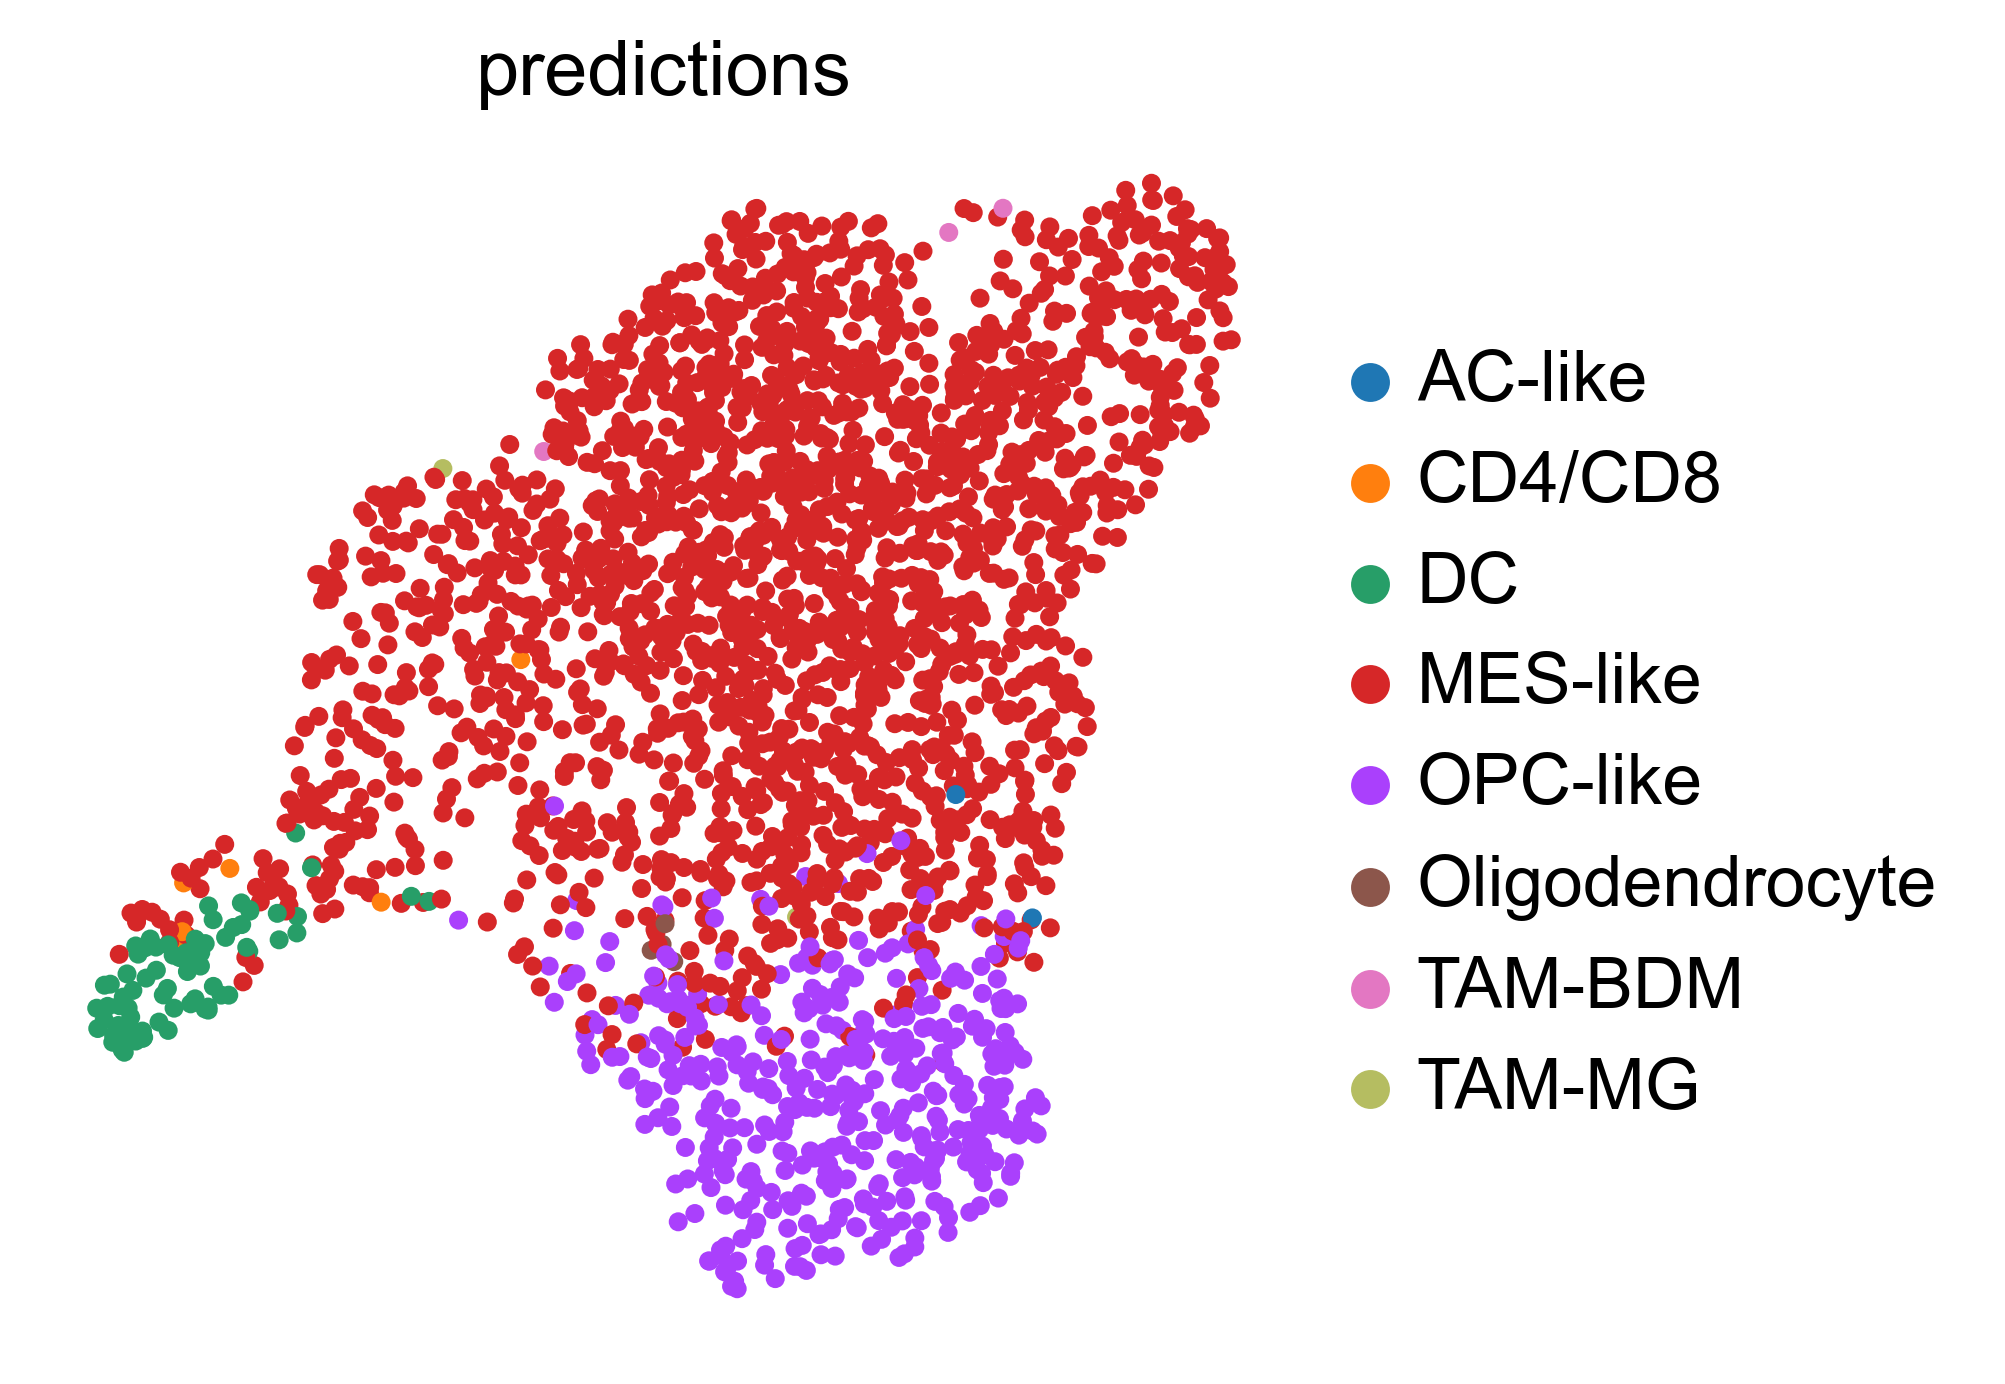

In [23]:
## Visualization
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)

sc.pl.umap(query_latent,
           color=['predictions'],
           frameon=False,
           wspace=0.6,
           )

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


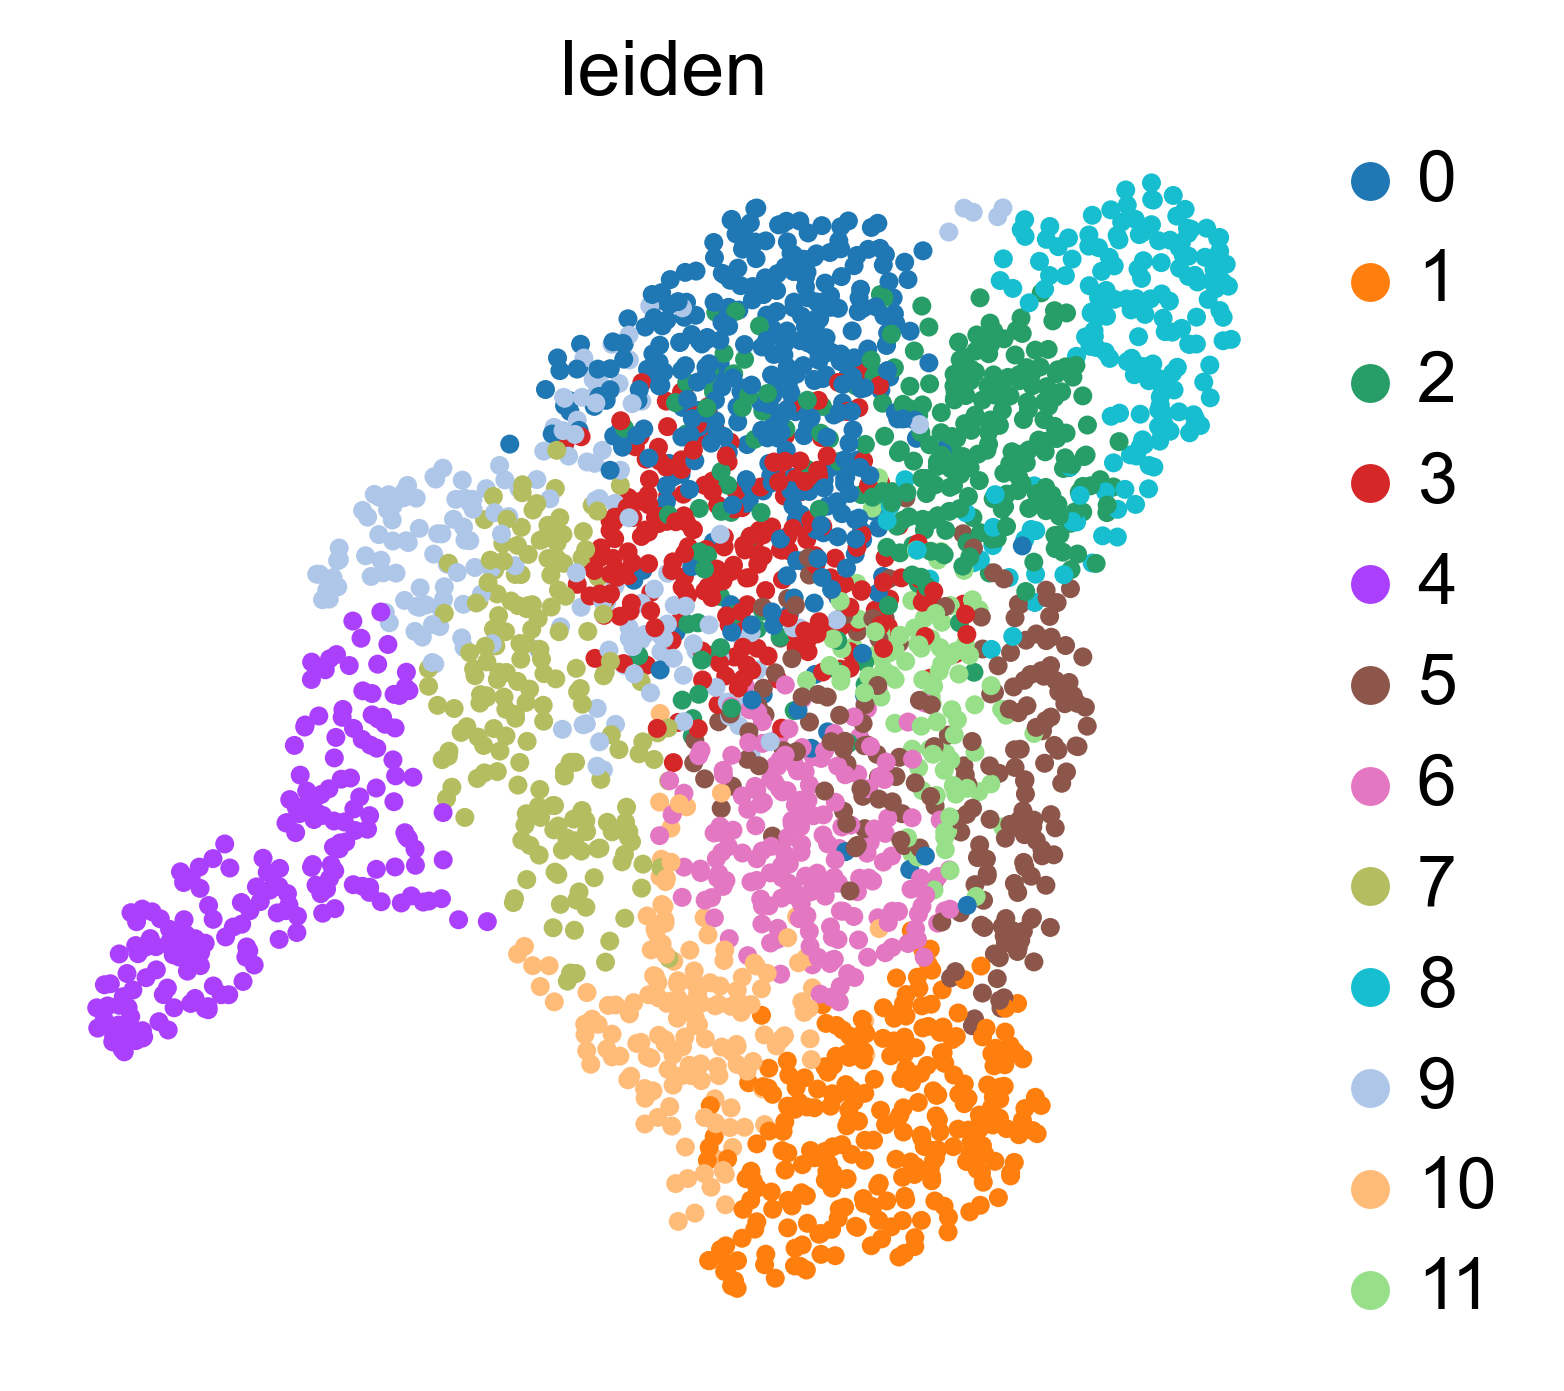

In [24]:
sc.pl.umap(query_latent,
           color=['leiden'],
           frameon=False,
           wspace=0.6,
           )

In [63]:
#save latent representation-latns
query_latent.write("./scarches_SCANVI)latens1.h5ad")



: 

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'log

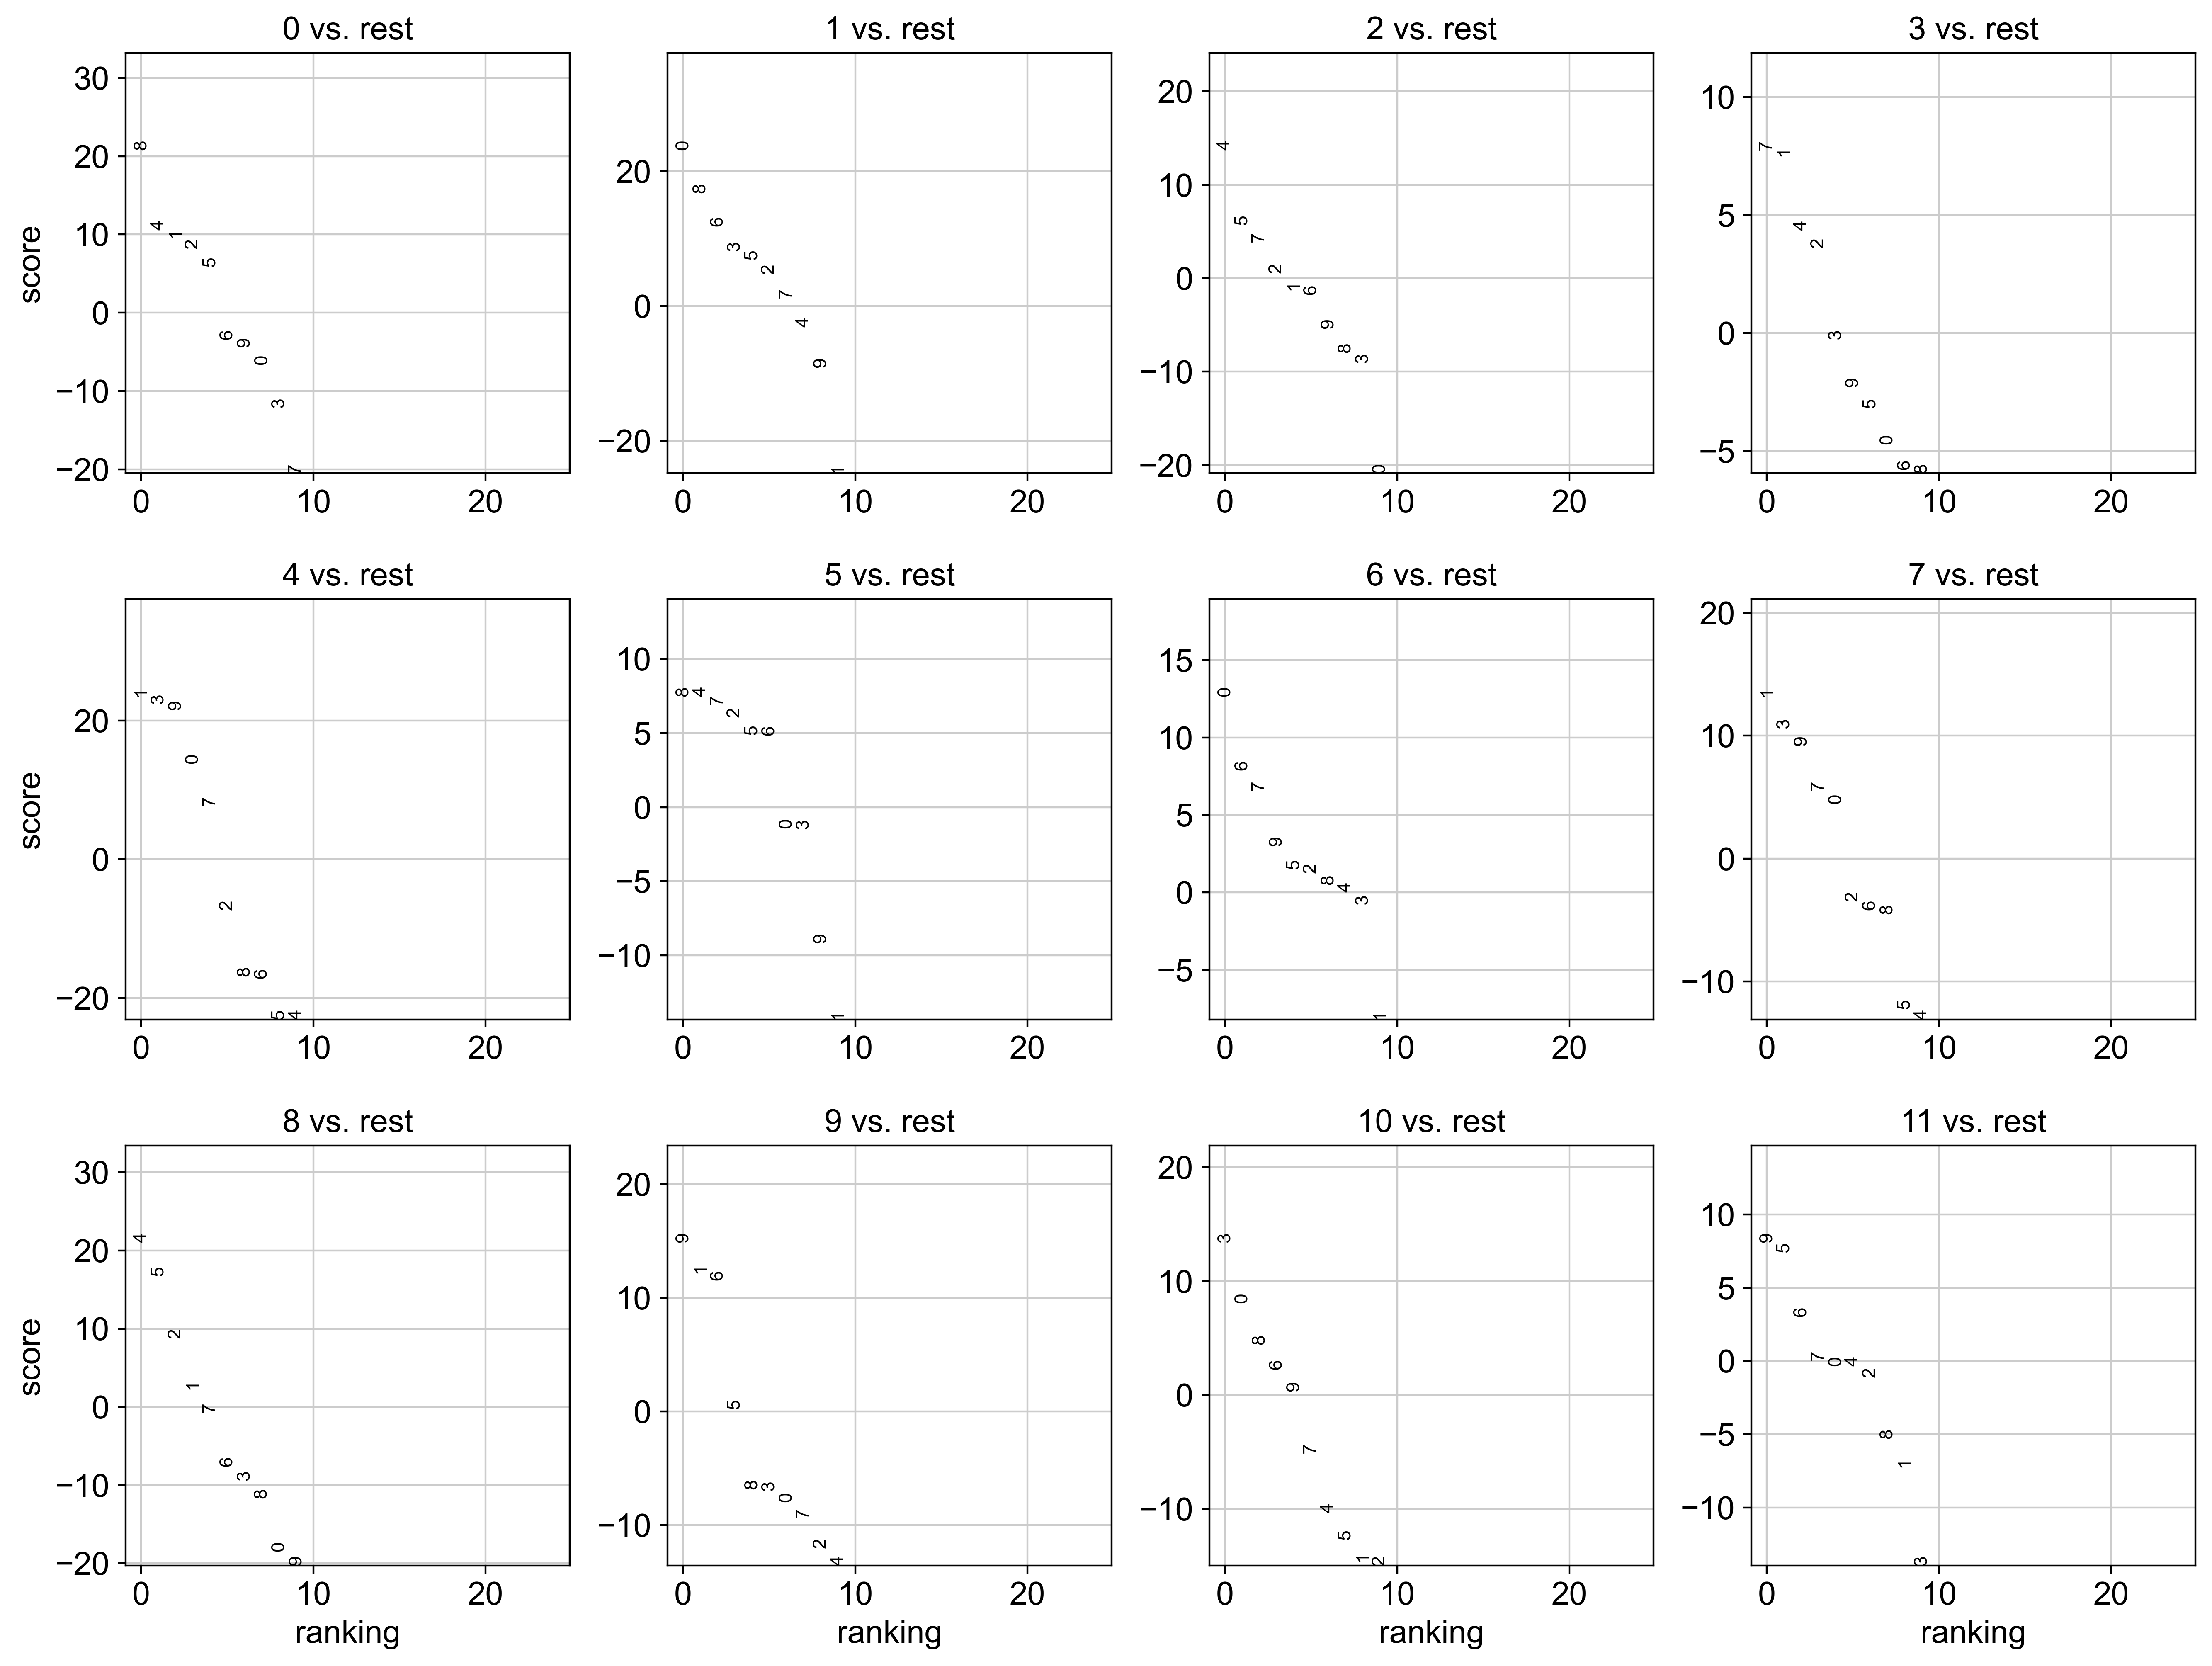

In [54]:
#extract marker genes
sc.tl.rank_genes_groups(query_latent, groupby='leiden', method='wilcoxon')

sc.pl.rank_genes_groups(query_latent, n_genes=25, sharey=False)



In [29]:
#plot spatial
# target_adata
query_latent

AnnData object with n_obs × n_vars = 2565 × 10
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'CellID', 'author', '_scvi_batch', '_scvi_labels', 'predictions', 'ref_or_query', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'predictions_colors', 'leiden_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [42]:
target_adata

AnnData object with n_obs × n_vars = 2565 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'CellID', 'author', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'MT_gene', 'gene_symbols', 'ensembl'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'CellID_colors', 'sample_colors'
    obsm: 'spatial', 'MT'
    layers: 'counts'

In [55]:
query_latent.obs['predictions']

spot_id
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1    OPC-like
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1          DC
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1    OPC-like
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1    MES-like
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1    MES-like
                                                    ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1    MES-like
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1    MES-like
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1    MES-like
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1    MES-like
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1    MES-like
Name: predictions, Length: 2565, dtype: category
Categories (8, object): ['AC-like', 'CD4/CD8', 'DC', 'MES-like', 'OPC-like', 'Oligodendrocyte', 'TAM-BDM', 'TAM-MG']

In [61]:
query_latent

AnnData object with n_obs × n_vars = 2565 × 10
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'CellID', 'author', '_scvi_batch', '_scvi_labels', 'predictions', 'ref_or_query', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'predictions_colors', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [60]:
og_visium = read_and_qc(
    "A-AK40374-AK40375_225GY5LT3", path="/Users/carbs/Downloads/Spatial_Meta/visium/"
)



# # #add predictions to spatial data
# og_visium.obs['predictions'] = query_latent.obs['predictions']
# og_visium.obs['leiden'] = query_latent.obs['leiden']

# #save spatial data
# og_visium.write("A-AK40374-AK40375_225GY5LT3_with_predictions.h5ad")


/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_16983/4038762396.py:60: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["sample"] = [str(i) for i in adata.obs["sample"]]


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [48]:
combined_emb = sc.concat(
    (source_adata, query_latent), index_unique=None, join="outer"
)  # index_unique="_", batch_key="ref_or_query")
# adata_full = source_adata.concatenate(adata_query, batch_key="ref_query")
# full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))


/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [49]:
combined_emb

AnnData object with n_obs × n_vars = 341129 × 5010
    obs: 'author', 'patient', 'method', 'CellID', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'ref_or_query', 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'predictions', 'leiden'
    obsm: 'X_umap'
    layers: 'counts'

In [50]:
## Visualization
sc.pp.neighbors(combined_emb)
sc.tl.leiden(combined_emb)
sc.tl.umap(combined_emb)



         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


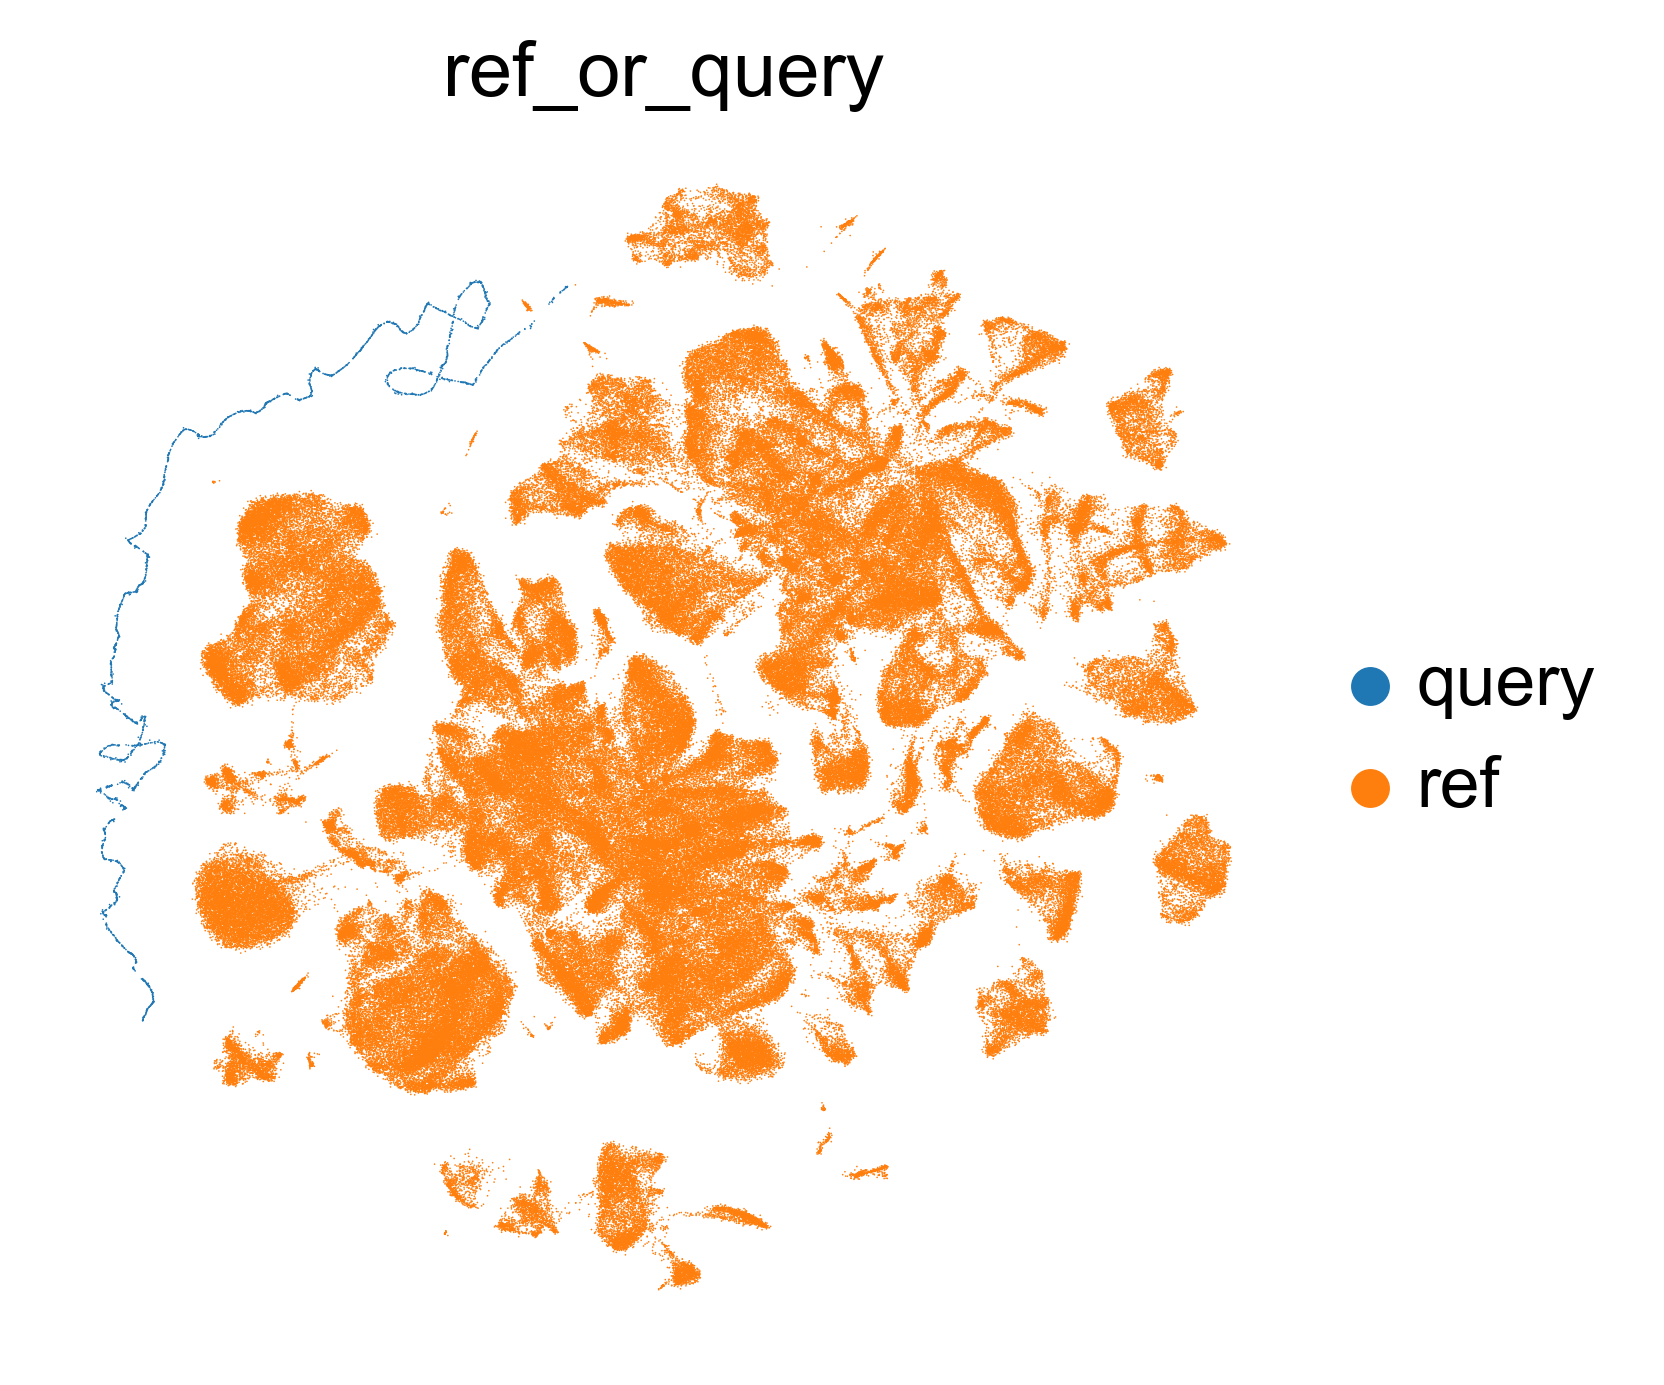

In [51]:
sc.pl.umap(combined_emb,
           color=['ref_or_query'],
           frameon=False,
           wspace=0.6,
           )

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


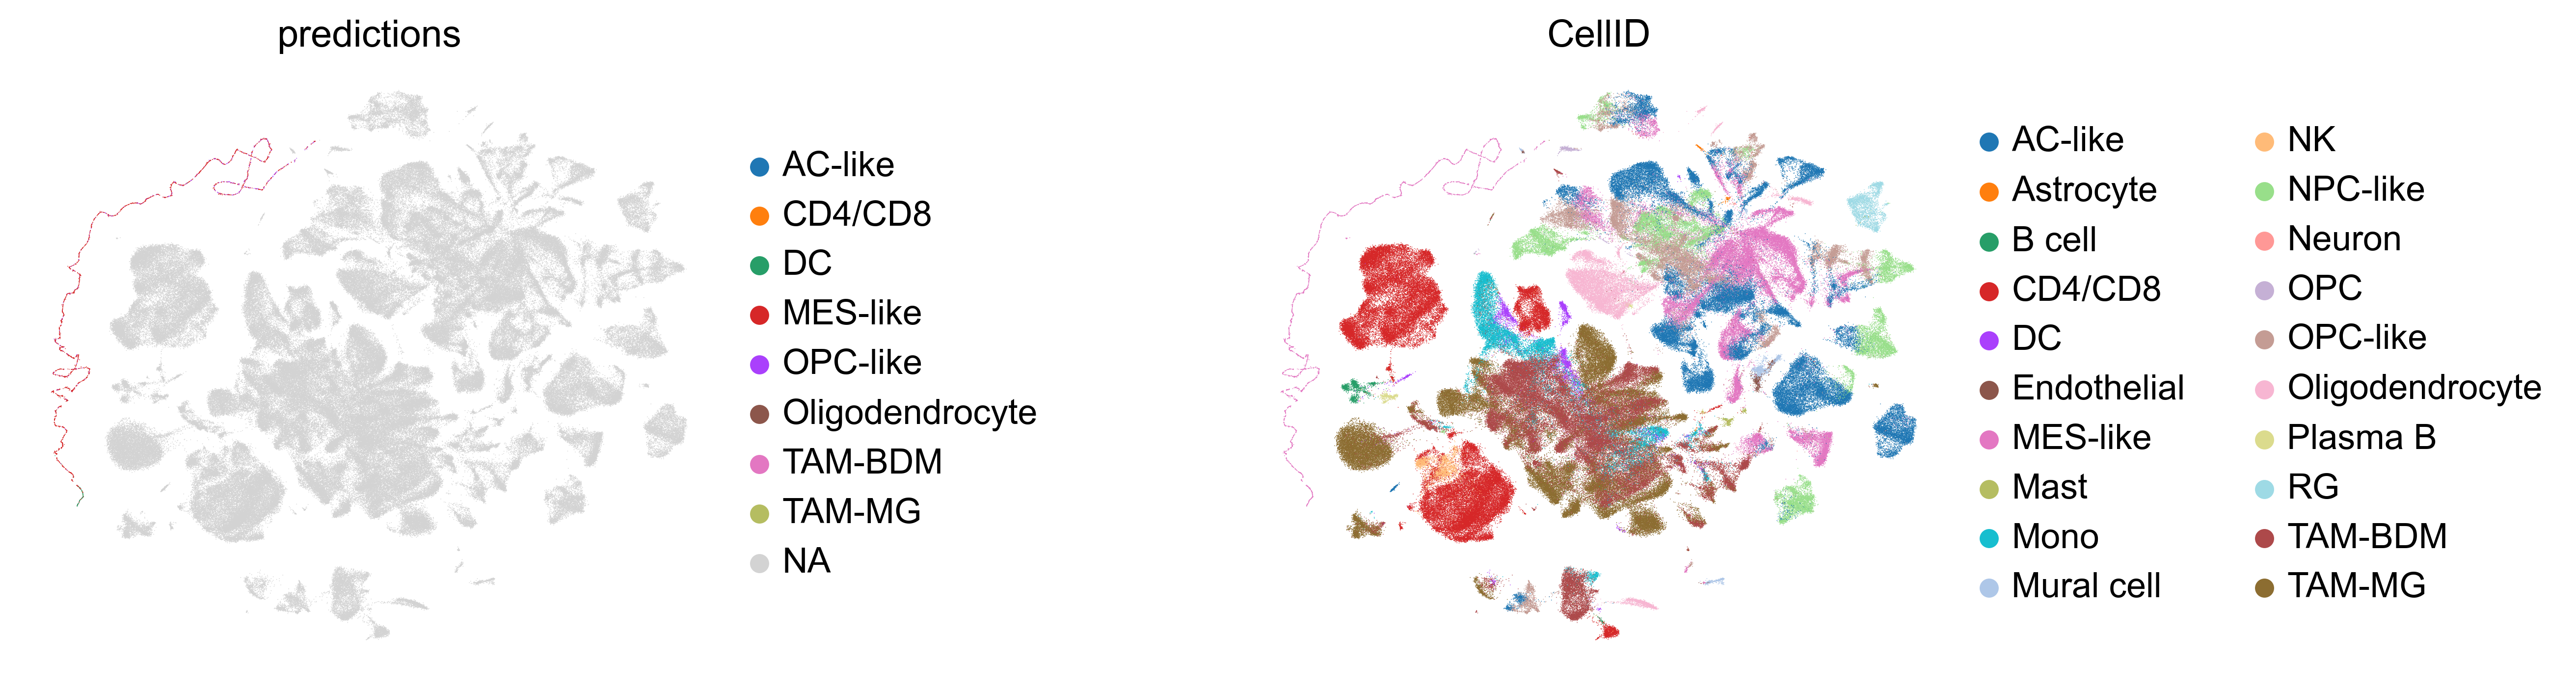

In [52]:
sc.pl.umap(combined_emb,
           color=['predictions','CellID'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
#get accuracy of the model now


In [ ]:
source_adata.obs

In [31]:
full_latent.obs

leiden
0           4
1           3
2           0
3           4
4           4
...       ...
341124     34
341125     34
341126     34
341127     34
341128     34

[341129 rows x 1 columns]

KeyError: 'Could not find key predictions in .var_names or .obs.columns.'

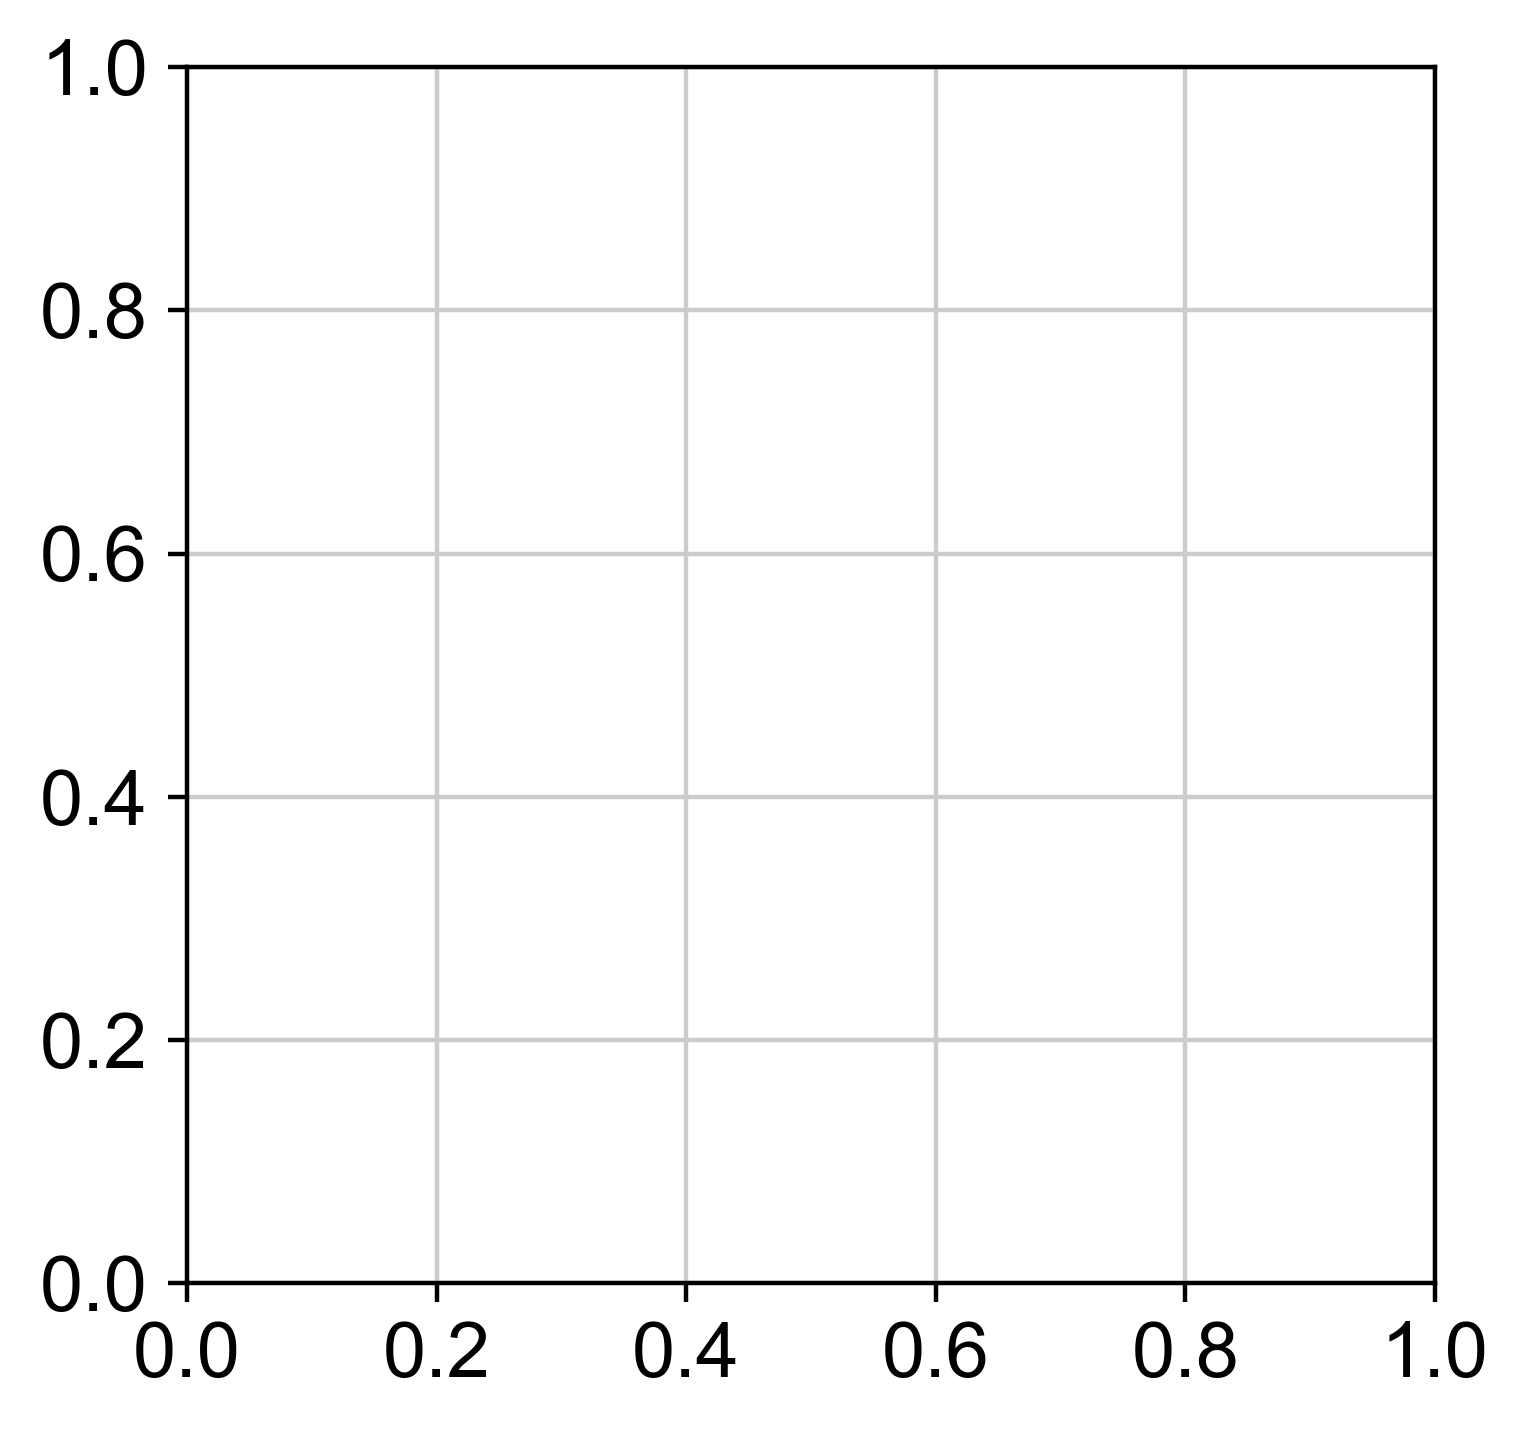

In [56]:

map2 = pd.read_csv(
        "/Users/carbs/Downloads/Spatial_Meta/visium/A-AK40374-AK40375_225GY5LT3/SPATIAL_RNA_COUNTER_CS/SPATIAL_RNA_COUNTER/_TARGETED_ANALYZER/CALCULATE_TARGETED_METRICS/fork0/join-u63f66a1acf/files/per_feature_metrics_csv.csv"
    )
# extract only column with name probe_id
# mapp2 = mapp2[["probe_id"]]

# #split probe_ids ENSG00000000003|TSPAN6|41ef80c
# mapp2 = mapp2["probe_id"].str.split("|", expand=True)
# #rename columns
# mapp2.columns = ["gene_id", "gene_name", "somehashoridk"]

# keep only colums with name feature_type,feature_id,feature_name,
mapp2 = map2[["feature_type", "feature_id", "feature_name"]]
# rename columns
mapp2.columns = ["feature_type", "gene_id", "gene_name"]

# transfrom  b'ENSG00000130203' to ENSG00000130203 by removing b' and '
mapp2["gene_id"] = mapp2["gene_id"].str[2:-1]



#find in gene set
gene_setttt = pd.read_csv("./genes_for_mapping_ok.csv")
gene_setttt.head()

for gene in diff_gene_names:
    #find index in gene_symbols
    # print(gene)
    ens_name = gene_setttt[gene_setttt['gene_symbols'] == gene]['Unnamed: 0'].values[0]
    # print(ens_name)

    #find it in map2

    lookup = mapp2[mapp2['gene_id'] == ens_name]['gene_name']
    #check if exists
    if lookup.empty:
        print('not found in map2', gene, ens_name)
    else:
        my_name = lookup.values[0]
        # print('found in map2', my_name)

        #rename gene in target_adata to my_name

        #chekc if genes name different
        if gene != my_name:
            print('different gene names', gene, my_name)

            #loc[row_indexer,col_indexer]

            
            print('replaced', my_name, gene)



different gene names CTB-61M7.2 AC245128.3


/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_61413/1269748478.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapp2["gene_id"] = mapp2["gene_id"].str[2:-1]


KeyError: 'AC245128.3'

In [7]:
target_adata.var.index

Index(['TRIM63', 'CCP110', 'CCDC186', 'RTN1', 'RHOG', 'SGO1', 'TPM2', 'TNRC6C',
       'ZNF559', 'ANKAR',
       ...
       'LINC00323', 'SNHG19', 'BISPR', 'LINC00265', 'IL9R', 'HSPA7', 'MAFF',
       'MLXIPL', 'HYPK', 'ARHGAP27'],
      dtype='object', length=5000)

In [8]:
source_adata.var.index

Index(['TRIM63', 'CCP110', 'CCDC186', 'RTN1', 'RHOG', 'SGO1', 'TPM2', 'CKS2',
       'ARL6IP1', 'RCOR2',
       ...
       'GUCY1A1', 'PLAAT1', 'PPDPFL', 'H2AC16', 'H4C1', 'OBSCN-AS1', 'H4C4',
       'HOATZ', 'LINC02694', 'MUCL3'],
      dtype='object', length=5000)

In [62]:
source_adata.obs['author']

PJ017_0                             Yuan2018
PJ017_1                             Yuan2018
PJ017_2                             Yuan2018
PJ017_3                             Yuan2018
PJ017_4                             Yuan2018
                                   ...      
E100_GEX_TTTGTCACATGCAATC-1    Mathewson2021
E100_GEX_TTTGTCAGTAGAGCTG-1    Mathewson2021
E100_GEX_TTTGTCAGTATCGCAT-1    Mathewson2021
E100_GEX_TTTGTCATCTGTCTCG-1    Mathewson2021
E100_GEX_TTTGTCATCTTTACGT-1    Mathewson2021
Name: author, Length: 338564, dtype: category
Categories (17, object): ['Bhaduri2020', 'Couturier2020', 'Darmanis2017', 'Goswami2019', ..., 'Wu2020', 'Yu2020', 'Yuan2018', 'Zhao2020']

In [26]:
target_adata.obs

author patient method    CellID  \
PJ017_0                           Yuan2018   PJ017   cell  MES-like   
PJ017_1                           Yuan2018   PJ017   cell  OPC-like   
PJ017_2                           Yuan2018   PJ017   cell   TAM-BDM   
PJ017_3                           Yuan2018   PJ017   cell  MES-like   
PJ017_4                           Yuan2018   PJ017   cell   AC-like   
...                                    ...     ...    ...       ...   
E100_GEX_TTTGTCACATGCAATC-1  Mathewson2021    E100   cell   CD4/CD8   
E100_GEX_TTTGTCAGTAGAGCTG-1  Mathewson2021    E100   cell   CD4/CD8   
E100_GEX_TTTGTCAGTATCGCAT-1  Mathewson2021    E100   cell   CD4/CD8   
E100_GEX_TTTGTCATCTGTCTCG-1  Mathewson2021    E100   cell   CD4/CD8   
E100_GEX_TTTGTCATCTTTACGT-1  Mathewson2021    E100   cell   CD4/CD8   

                             _scvi_batch  _scvi_labels  _scvi_local_l_mean  \
PJ017_0                               15             6            6.441088   
PJ017_1                               15            14            6.441088   
PJ017_2                               15            18            6.441088   
PJ017_3                               15             6            6.441088   
PJ017_4                               15             0            6.441088   
...                                  ...           ...                 ...   
E100_GEX_TTTGTCACATGCAATC-1            5             3            6.911591   
E100_GEX_TTTGTCAGTAGAGCTG-1            5             3            6.911591   
E100_GEX_TTTGTCAGTATCGCAT-1            5             3            6.911591   
E100_GEX_TTTGTCATCTGTCTCG-1            5             3            6.911591   
E100_GEX_TTTGTCATCTTTACGT-1            5             3            6.911591   

                             _scvi_local_l_var  
PJ017_0                               0.417351  
PJ017_1                               0.417351  
PJ017_2                               0.417351  
PJ017_3                               0.417351  
PJ017_4                               0.417351  
...                                        ...  
E100_GEX_TTTGTCACATGCAATC-1           0.410996  
E100_GEX_TTTGTCAGTAGAGCTG-1           0.410996  
E100_GEX_TTTGTCAGTATCGCAT-1           0.410996  
E100_GEX_TTTGTCATCTGTCTCG-1           0.410996  
E100_GEX_TTTGTCATCTTTACGT-1           0.410996  

[338564 rows x 8 columns]

In [27]:
#edit target adata  obs to match source adata obs
#find missing obs
print( len(set(source_adata.obs) - set(target_adata.obs) ))
#get missing obs
missing_obs = set(source_adata.obs) - set(target_adata.obs)
missing_obs


#remove missing obs from target adata

#remove all observarions expecpt CellID

target_adata.obs = target_adata.obs[["CellID"]]





7


In [41]:
#concatenate source and target adata

target_adata.obs['CellID'] = "Unknown"
adata = anndata.concat([source_adata, target_adata], join="outer")

#set author of adata where missing
adata.obs['author'] = adata.obs['author'].fillna('Yuan2018')

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [42]:
adata.obs

author patient method  \
PJ017_0                                         Yuan2018   PJ017   cell   
PJ017_1                                         Yuan2018   PJ017   cell   
PJ017_2                                         Yuan2018   PJ017   cell   
PJ017_3                                         Yuan2018   PJ017   cell   
PJ017_4                                         Yuan2018   PJ017   cell   
...                                                  ...     ...    ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1  Yuan2018     NaN    NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1  Yuan2018     NaN    NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1  Yuan2018     NaN    NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1  Yuan2018     NaN    NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1  Yuan2018     NaN    NaN   

                                                  CellID  _scvi_batch  \
PJ017_0                                         MES-like         15.0   
PJ017_1                                         OPC-like         15.0   
PJ017_2                                          TAM-BDM         15.0   
PJ017_3                                         MES-like         15.0   
PJ017_4                                          AC-like         15.0   
...                                                  ...          ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1   Unknown          NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1   Unknown          NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1   Unknown          NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1   Unknown          NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1   Unknown          NaN   

                                                _scvi_labels  \
PJ017_0                                                  6.0   
PJ017_1                                                 14.0   
PJ017_2                                                 18.0   
PJ017_3                                                  6.0   
PJ017_4                                                  0.0   
...                                                      ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1           NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1           NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1           NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1           NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1           NaN   

                                                _scvi_local_l_mean  \
PJ017_0                                                   6.441088   
PJ017_1                                                   6.441088   
PJ017_2                                                   6.441088   
PJ017_3                                                   6.441088   
PJ017_4                                                   6.441088   
...                                                            ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1                 NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1                 NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1                 NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1                 NaN   
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1                 NaN   

                                                _scvi_local_l_var  
PJ017_0                                                  0.417351  
PJ017_1                                                  0.417351  
PJ017_2                                                  0.417351  
PJ017_3                                                  0.417351  
PJ017_4                                                  0.417351  
...                                                           ...  
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1                NaN  
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1                NaN  
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1    

In [28]:
target_adata.obs

CellID
spot_id                                                
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1  Unknown
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1  Unknown
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1  Unknown
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1  Unknown
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1  Unknown
...                                                 ...
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1  Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1  Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1  Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1  Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1  Unknown

[2565 rows x 1 columns]

In [6]:
target_adata.obs['author'] = vae.unlabeled_category_

In [7]:
target_adata.obs["author"] 

spot_id
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1    Unknown
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1    Unknown
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1    Unknown
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1    Unknown
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1    Unknown
                                                   ...   
A-AK40374-AK40375_225GY5LT3_TTGTTCAGTGTGCTAC-1    Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTCTAGATACGCT-1    Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTGTGTGTCAAGA-1    Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTTCACATCCAGG-1    Unknown
A-AK40374-AK40375_225GY5LT3_TTGTTTCATTAGTCTA-1    Unknown
Name: author, Length: 2565, dtype: object

/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_61413/1598559571.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_query.concatenate(source_adata,batch_key='author')
/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 341129 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'CellID', 'author', '_scvi_batch', 'patient', 'method', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'SYMBOL-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'MT_gene-0', 'gene_symbols-0', 'ensembl-0', 'feature_types-1', 'genome-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable_nbatches-1', 'highly_variable_intersection-1'
    layers: 'counts'

In [67]:
print( len(set(source_adata.obs) - set(adata_query.obs) ))
#get missing obs
missing_obs = set(source_adata.obs) - set(adata_query.obs)
missing_obs

5


{'_scvi_labels',
 '_scvi_local_l_mean',
 '_scvi_local_l_var',
 'method',
 'patient'}

In [43]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata=target_adata, reference_model=ref_path_coberted,inplace=False
)


adata_full_ = adata_query.concatenate(source_adata,batch_key='author')


#find missing obs
print( len(set(source_adata.obs) - set(adata_query.obs) ))
#get missing obs
missing_obs = set(source_adata.obs) - set(adata_query.obs)
missing_obs

INFO     File /Users/carbs/Downloads/Spatial_Meta/scraches_down_converted_fromlegacy/model.pt already downloaded   
INFO     Found 100.0% reference vars in query data.                                                                


/var/folders/wk/1gf2_m552kl8lnst82lpjrn00000gn/T/ipykernel_79381/811839962.py:6: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_full_ = adata_query.concatenate(source_adata,batch_key='author')


6


/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


{'_scvi_batch',
 '_scvi_labels',
 '_scvi_local_l_mean',
 '_scvi_local_l_var',
 'method',
 'patient'}

In [46]:
adata_full_.obs.author

A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1-0    0
                                                   ..
E100_GEX_TTTGTCACATGCAATC-1-1                       1
E100_GEX_TTTGTCAGTAGAGCTG-1-1                       1
E100_GEX_TTTGTCAGTATCGCAT-1-1                       1
E100_GEX_TTTGTCATCTGTCTCG-1-1                       1
E100_GEX_TTTGTCATCTTTACGT-1-1                       1
Name: author, Length: 341129, dtype: category
Categories (2, object): ['0', '1']

In [47]:
adata_full_.obs

#split data into train and test only keep rows where CellID is vae.unlabeled_category_

my_data = adata_full_[adata_full_.obs['CellID'] == vae.unlabeled_category_]

my_data.obs

my_data.obs['author']

adata_full_.obs['author']


A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1-0    0
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1-0    0
                                                   ..
E100_GEX_TTTGTCACATGCAATC-1-1                       1
E100_GEX_TTTGTCAGTAGAGCTG-1-1                       1
E100_GEX_TTTGTCAGTATCGCAT-1-1                       1
E100_GEX_TTTGTCATCTGTCTCG-1-1                       1
E100_GEX_TTTGTCATCTTTACGT-1-1                       1
Name: author, Length: 341129, dtype: category
Categories (2, object): ['0', '1']

Index(['TRIM63', 'CCP110', 'CCDC186', 'RTN1', 'RHOG', 'SGO1', 'TPM2', 'CKS2',
       'ARL6IP1', 'RCOR2',
       ...
       'GUCY1A1', 'PLAAT1', 'PPDPFL', 'H2AC16', 'H4C1', 'OBSCN-AS1', 'H4C4',
       'HOATZ', 'LINC02694', 'MUCL3'],
      dtype='object', length=5000)

In [20]:
adata_full_.obs

in_tissue array_row  \
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1-0         1         0   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1-0         1        59   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1-0         1        14   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1-0         1        43   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1-0         1        47   
...                                                    ...       ...   
E100_GEX_TTTGTCACATGCAATC-1-1                          NaN       NaN   
E100_GEX_TTTGTCAGTAGAGCTG-1-1                          NaN       NaN   
E100_GEX_TTTGTCAGTATCGCAT-1-1                          NaN       NaN   
E100_GEX_TTTGTCATCTGTCTCG-1-1                          NaN       NaN   
E100_GEX_TTTGTCATCTTTACGT-1-1                          NaN       NaN   

                                                 array_col  \
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1-0        16   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1-0        19   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1-0        94   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1-0         9   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1-0        13   
...                                                    ...   
E100_GEX_TTTGTCACATGCAATC-1-1                          NaN   
E100_GEX_TTTGTCAGTAGAGCTG-1-1                          NaN   
E100_GEX_TTTGTCAGTATCGCAT-1-1                          NaN   
E100_GEX_TTTGTCATCTGTCTCG-1-1                          NaN   
E100_GEX_TTTGTCATCTTTACGT-1-1                          NaN   

                                                                       sample  \
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1-0  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1-0  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1-0  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1-0  A-AK40374-AK40375_225GY5LT3   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1-0  A-AK40374-AK40375_225GY5LT3   
...                                                                       ...   
E100_GEX_TTTGTCACATGCAATC-1-1                                             NaN   
E100_GEX_TTTGTCAGTAGAGCTG-1-1                                             NaN   
E100_GEX_TTTGTCAGTATCGCAT-1-1                                             NaN   
E100_GEX_TTTGTCATCTGTCTCG-1-1                                             NaN   
E100_GEX_TTTGTCATCTTTACGT-1-1                                             NaN   

                                                  n_genes_by_counts  \
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1-0             3273.0   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1-0             3273.0   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1-0             4100.0   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1-0             1878.0   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1-0             1323.0   
...                                                             ...   
E100_GEX_TTTGTCACATGCAATC-1-1                                   NaN   
E100_GEX_TTTGTCAGTAGAGCTG-1-1                                   NaN   
E100_GEX_TTTGTCAGTATCGCAT-1-1                                   NaN   
E100_GEX_TTTGTCATCTGTCTCG-1-1                                   NaN   
E100_GEX_TTTGTCATCTTTACGT-1-1                                   NaN   

                                                  log1p_n_genes_by_counts  \
A-AK40374-AK40375_225GY5LT3_AAACAACGAATAGTTC-1-0                 8.093768   
A-AK40374-AK40375_225GY5LT3_AAACACCAATAACTGC-1-0                 8.093768   
A-AK40374-AK40375_225GY5LT3_AAACAGAGCGACTCCT-1-0                 8.318986   
A-AK40374-AK40375_225GY5LT3_AAACAGCTTTCAGAAG-1-0                 7.538495   
A-AK40374-AK40375_225GY5LT3_AAACAGGGTCTATATT-1-0                 7.188413   
...                                                                   ...   
E100_GEX_TTTGTCACATGCAATC-1-1                                         NaN 

In [100]:
#make target_adata have same obs as source_adata
# {'_scvi_batch',
#  '_scvi_labels',
#  '_scvi_local_l_mean',
#  '_scvi_local_l_var',
#  'author',
#  'method',
#  'patient'}

#add missing obs to target_adata but fill with values that dont effect the model

# for obs in missing_obs:
#     target_adata.obs[obs] = 'missing'
    

#set author for target_adata
target_adata.obs['author'] = 'Bhaduri2020' 


#preprae ann data for training
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata=target_adata, reference_model=ref_path_coberted,inplace=False
)



INFO     File /Users/carbs/Downloads/Spatial_Meta/scraches_down_converted_fromlegacy/model.pt already downloaded   
INFO     Found 100.0% reference vars in query data.                                                                


In [103]:
adata_query

AnnData object with n_obs × n_vars = 2565 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'CellID', 'author', '_scvi_batch'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'MT_gene', 'gene_symbols', 'ensembl'
    obsm: 'spatial', 'MT'
    layers: 'counts'

In [73]:
source_adata

AnnData object with n_obs × n_vars = 338564 × 5000
    obs: 'author', 'patient', 'method', 'CellID', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'

In [66]:
vae.registry_["setup_args"]


{'labels_key': 'CellID',
 'unlabeled_category': 'Unknown',
 'layer': 'counts',
 'batch_key': 'author',
 'size_factor_key': None,
 'categorical_covariate_keys': None,
 'continuous_covariate_keys': None}

In [34]:

## Perform surgery on GBmap core reference and train on query dataset without cell type labels

model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path_coberted,
    freeze_dropout=True,
    inplace_subset_query_vars=True
    # your adata must have the same gene length (5000) and names as the GBmap core (source_adata)
    # `inplace_subset_query_vars = True` will subset and reorder the vars to tarin the model properly
    # In case you want to subet and tidy up your AnnData object beforehand, you can use the file genes_for_mapping.csv uploaded in this repository
    # and the function `subset_and_pad_adata` developed by Lisa Sikkema and Theis team
    # You can find it here: https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/scripts/preprocessing.py
)

model._unlabeled_indices = np.arange(adata_query.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))


INFO     File /Users/carbs/Downloads/Spatial_Meta/scraches_down_converted_fromlegacy/model.pt already downloaded   
searching for Yuan2018
searching for MES-like
Labelled Indices:  0
Unlabelled Indices:  2565


/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/scvi/model/_scanvi.py:140: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [37]:

query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs["author"] = target_adata.obs[
    "author"
].tolist()
query_latent.obs[
    "CellID"
] = model.predict()  # get predictions of cell anotation from the model

## Visualization
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)

sc.pl.umap(
    query_latent,
    color=["predictions"],
    frameon=False,
    wspace=0.6,
)

## Get latent representation of core GBmap + query dataset and compute new UMAP

adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))

## Visualization
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

sc.pl.umap(
    full_latent,
    color=["any_metadata_of_interest"],
    frameon=False,
    wspace=0.6,
)

RuntimeError: Trying to query inferred values from an untrained model. Please train the model first.